## 12.5 Introduction to Generative Adversarial Networks (GANs)

In [1]:
import os, sys, pathlib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo

import tensorflow as tf

In [2]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')  # 'My Drive' is the default name of Google Drives
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/8-generative-deep-learning')
    os.listdir() 

### What are GANs? An anecdotal introduction

1. An uninspired artist produces some fake Picassos.
2. The fakes are mixed with original Picassos and presented at a fair.
3. An art critic wants to buy real Picassos, and therefore tries to recognise the real ones from the fakes.
4. The forger sees the dealer's choices, uses this feedback to improve the quality of new fakes!
5. The game continues, **ideally both players get ever better at what they do**.

### Game Theory

This is known in game theory as a **Minimax Game**.

The *fakeness* of a painting is just a number, say from zero to one.

Given one fake painting:
- the *artist* wants to **minimise** the critic's accuracy (fool the critic!).
- the *critic* wants to **maximise** its own accuracy (= its ability to triage);

→ **mini-max**

The game is entangled because the *artist* is not the one giving the score, the *critic* is. The *artist* is trying to influence the *critic's* judgment by changing its production.

A GAN network is there fore **two networks in one**, trained together, with: 
- a **generator** that takes a random point in the latent space and decodes it into a synthetic image;
- a **discriminator** predicts whether an image came from the training set or from the generator.

The generator is the **artist**, the discriminator is the **critic**.

### Training instability

As the generator tries to fool the discriminator, and the discriminator to detect the fakes, **the system is constantly evolving**.

There is no guarantee that the latent space is structured or even continuous.

A GAN does not have a fixed loss landscape (loss plotted against parameters) – the entire landsape changes with each step.

The aim is not minimisation, but a **(Nash) equilibrium** (where neither player can improve their strategy).

This involves a **lot** of bells and whistles to make it work properly.

---

### 12.5.1 A schematic GAN implementation

<!-- ![Chollet GANs](images/chollet.gans.p.402.png) -->

<img src="https://drive.google.com/uc?id=17Y6of5Nu5UfvK_nseE7OXuQlxBLClaGo">


<small>DLWP, p.402</small>

### Architecture

#### The Generator

1. Maps vectors from the latent space to images (*decoding*/*generating*).   
   The vectors are random $n$-dimensional vectors (normal distribution) where $n$ is the dimension of the latent space.
2. A batch of images is created, with generated **and real ones**, from any dataset (e.g. CelebA, CIFAR10, your own);

#### The Discriminator

3. Processes the batch of images, and outputs a binary score in $[0, 1]$, i.e. a **probability** for each image in the mixed set;

#### Combined training

4. The discriminator is frozen;
5. The generator is trained to **maximise** the discriminator loss,  
    i.e. to produce images **that the discriminator will classify as real**; 
6. The generator is frozen;
6. The discriminator is trained to **minimise its loss**,  
    i.e. to become better at spotting fakes.

### The Math

$$
\bbox[5px,border:2px solid red]
{
\min_G \max_D V(D, G)= \overbrace{Loss(D(x))}^{discriminator} + \overbrace{Loss(1 - D(G(z)))}^{generator}]
}
$$

$V$: "Value function": the whole GAN network  
$G, D$: Generator, Discriminator  
$x, z$: real image, latent space sample

### Note

The overall loss is formulated so that we can minimise the whole thing during training (as usual).

When $D$ is good, $Loss(D(x))$ is low.  
When $G$ is good, $Loss(1 - D(G(z)))$ is low ($D$ has been fooled, gives a 1 to a fake image).

### The Full Math

$$
\bbox[5px,border:2px solid red]
{
\min_G \max_D V(D, G)= \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))]
}
$$

$V$: "Value function": the whole GAN network  
$G, D$: Generator, Discriminator  
$x, z$: real image, latent space sample  
$\mathbb{E}_{x\sim p_{data}(x)}$: sampling from our (real) dataset   
$\mathbb{E}_{z\sim p_z(z)}$: sampling from the (fake) latent space

[Goodfellow et al. "Generative Adversarial Networks"](https://arxiv.org/abs/1406.2661)


<!-- <img style="height:750px" src="images/GAN.Edmond_de_Belamy.png"> -->
<img style="height:750px" src="https://drive.google.com/uc?id=1vuFJchYT5tOLdo6J6daLMMJf9zOrDSFk">

<small>[Obvious, *Edmond de Belamy*, 2016](https://en.wikipedia.org/wiki/Edmond_de_Belamy)</small>

---

### 12.5.2 A bag of tricks

- Sample from the latent space using a **normal distribution** (Gaussian), not a uniform one;
- GANs are likely to get stuck in all sorts of ways (it's an unstable, dynamic equilibrium):  
  we introduce **random noise** to the labels for the discriminator to prevent this;
- Sparse gradients can hinder GAN training, remedy: **strided convolutions** for downsampling instead of max pooling, and the **`LeakyReLU`** instead of `ReLu`;
- To avoid checkerboard artifacts caused by unequal coverage of the pixel space in the generator, use a kernel size **divisible by the stride size** with strided `Conv2DTranspose` or `Conv2D`.

<small>DLWP, p.404</small>

[Soumith Chintala, "How to Train a GAN? Tips and tricks to make GANs work"](https://github.com/soumith/ganhacks)

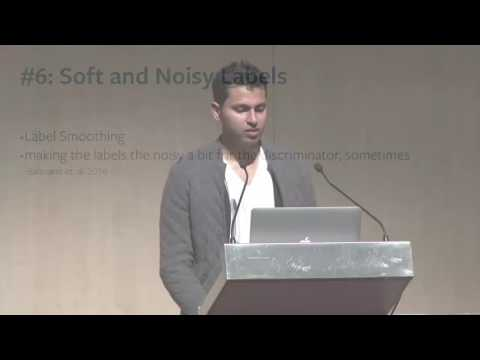

In [3]:
YouTubeVideo('X1mUN6dD8uE', width=853, height=480) #  NIPS 2016 Workshop on Adversarial Training - Soumith Chintala - How to train a GAN 

---

### 12.5.3 Getting our hands on the CelebA dataset

**Getting the CelebA data**

##### In Colab

```bash
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan
```

##### Locally


Download manually [here](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and unzip. (I chose the aligned version.)


**Creating a dataset from a directory of images**

In [2]:
basedir = pathlib.Path("celeba_gan") # this will fail if you don't have a `celeba_gan` dir
imgdir = basedir / "celeba_gan"      # with, inside it, another one with the same name containing the images
outputdir = basedir / "generated"

if not os.path.isdir(outputdir):
    os.mkdir(outputdir)

batch_size = 32 # 128
dataset = tf.keras.utils.image_dataset_from_directory(
    imgdir,
    label_mode=None,
    image_size=(64, 64),
    batch_size=batch_size,
    smart_resize=True
)

Found 111872 files belonging to 1 classes.


**Rescaling the images**

In [3]:
dataset = dataset.map(lambda x: x / 255.)

**Displaying the first image**

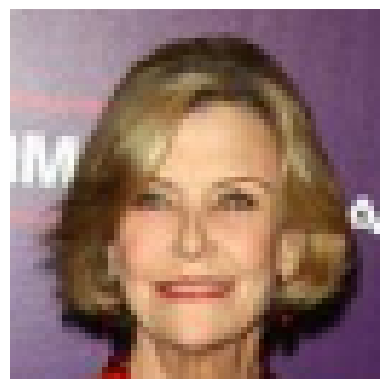

In [4]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

---

### 12.5.4 The discriminator

**The GAN discriminator network**

In [5]:
def build_discriminator():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
discriminator = build_discriminator()

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

---

### 12.5.5 The generator

**GAN generator network**

[`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) docs, like with VAEs.

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://drive.google.com/uc?id=1SnOH8oSc-Nm8BnfgBscZ9ZoreU4JFpxN)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://drive.google.com/uc?id=1WFs76_P33NQgvugVWPPyft_4zfWMhJ_9)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

In [6]:
def build_generator(latent_dim = 128):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128),
            tf.keras.layers.Reshape((8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator",
    )

generator = build_generator()

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

---

### 12.5.6 The adversarial network

**The GAN `Model`**

In [7]:
class GAN(tf.keras.Model):                                                  # subclassing `tf.keras.Model`
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")           # custom metrics
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):                   # `compile` required for `tf.keras.Model`
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):                                       # `train_step` required for `tf.keras.Model`
        batch_size = tf.shape(real_images)[0]

        # 1. TRAIN DISCRIMINATOR --------------------------------------------------

        random_latent_vectors = tf.random.normal(                            # feed a batch of generated
            shape=(batch_size, self.latent_dim)                             
        )
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0) # & real images
        labels = tf.concat( # (fake: 1, real: 0)
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        ) # (↓ label smoothing: inject randomness in the labels)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:                                      # gradient logic:
            predictions = self.discriminator(combined_images)                # Discriminator predicts
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # gradients to update
        self.d_optimizer.apply_gradients(                                    # our Discriminator
            zip(grads, self.discriminator.trainable_weights)
        )
        self.d_loss_metric.update_state(d_loss) # update loss

        # 2. TRAIN GENERATOR ------------------------------------------------------
        # (one common strategy is to repeat this part more than once per step)
        
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1)) # 0: real

        with tf.GradientTape() as tape:                                 # gradient logic:
            predictions = self.discriminator(                           # get predictions from Discriminator
                self.generator(random_latent_vectors)                   # from generated fake images
            )
            g_loss = self.loss_fn(misleading_labels, predictions)       # loss labels vs preds
        grads = tape.gradient(g_loss, self.generator.trainable_weights) # gradients to update
        self.g_optimizer.apply_gradients(                               # our Generator
            zip(grads, self.generator.trainable_weights)
        )
        self.g_loss_metric.update_state(g_loss) # update loss

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

**A callback that samples generated images during training**

In [8]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save(outputdir / f"generated_img_{epoch:03d}_{i}.png")

**Compiling and training the GAN**

In [34]:
epochs = 10 # ← Chollet has 100, you need a good GPU & patience for that!
latent_dim = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # very small learning rates!
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

**Reload a trained model**

In [35]:
reload = False # True to reload
generator_path = basedir / "generator_celeba_gan.h5"
discriminator_path = basedir / "discriminator_celeba_gan.h5"
if os.path.isfile(discriminator_path) and os.path.isfile(generator_path) and reload:
    gan.generator.load_weights(generator_path)
    gan.discriminator.load_weights(discriminator_path)

In [21]:
gan.fit(
    dataset, epochs=epochs, callbacks=[
        GANMonitor(num_img=10, latent_dim=latent_dim),
    ]
)

Epoch 1/10
3496/3496 [==============================] - 1219s 349ms/step - d_loss: 0.6457 - g_loss: 1.1211
Epoch 2/10
3496/3496 [==============================] - 1230s 352ms/step - d_loss: 0.6509 - g_loss: 1.1720
Epoch 3/10
3496/3496 [==============================] - 1229s 351ms/step - d_loss: 0.6672 - g_loss: 0.9988
Epoch 4/10
3496/3496 [==============================] - 1227s 351ms/step - d_loss: 0.6753 - g_loss: 0.9821
Epoch 5/10
3496/3496 [==============================] - 1213s 347ms/step - d_loss: 0.6802 - g_loss: 0.9782
Epoch 6/10
3496/3496 [==============================] - 1209s 346ms/step - d_loss: 0.6621 - g_loss: 1.0288
Epoch 7/10
3496/3496 [==============================] - 1221s 349ms/step - d_loss: 0.6386 - g_loss: 1.1085
Epoch 8/10
3496/3496 [==============================] - 1218s 348ms/step - d_loss: 0.6429 - g_loss: 1.0671
Epoch 9/10
3496/3496 [==============================] - 1220s 349ms/step - d_loss: 0.6394 - g_loss: 1.0479
Epoch 10/10
3496/3496 [==============

**Check the results**

In [36]:
def plot_gan_images(gan):
    n = 12
    img_size = 64   
    figure = np.zeros((img_size * n, img_size * n))

    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

    random_latent_vectors = tf.random.normal(shape=(n, latent_dim))
    generated_images = gan.generator(random_latent_vectors)
    generated_images = tf.cast(generated_images * 255, tf.uint8)

    # https://stackoverflow.com/a/54681765
    _, axs = plt.subplots(3, 4, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(generated_images, axs):
        ax.axis('off')
        ax.imshow(img.numpy())
    plt.show()    

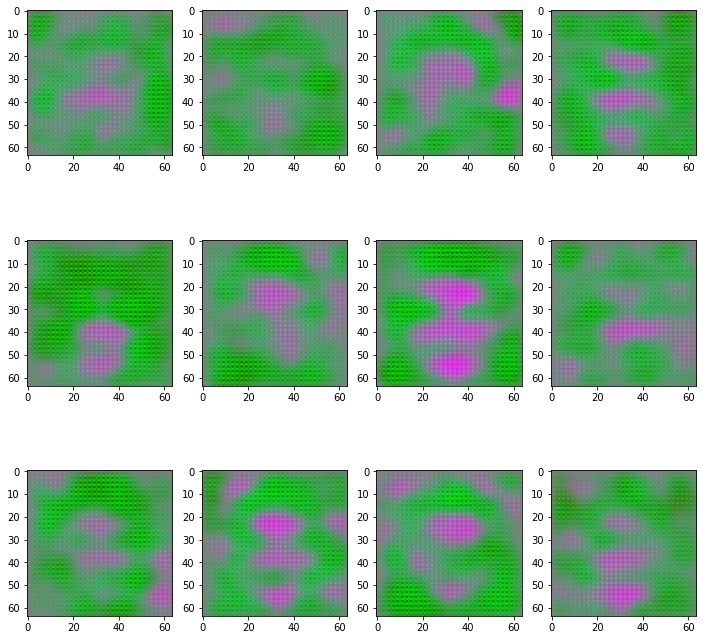

In [21]:
plot_gan_images(gan)

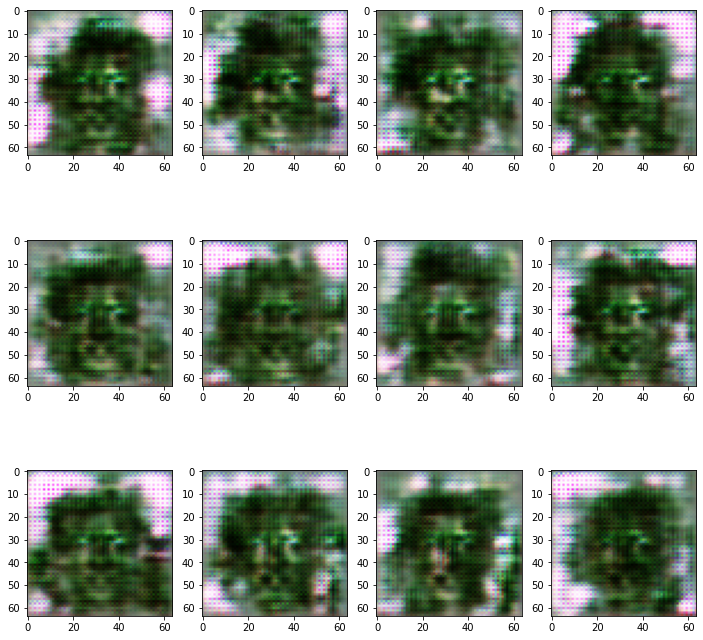

In [ ]:
plot_gan_images(gan)

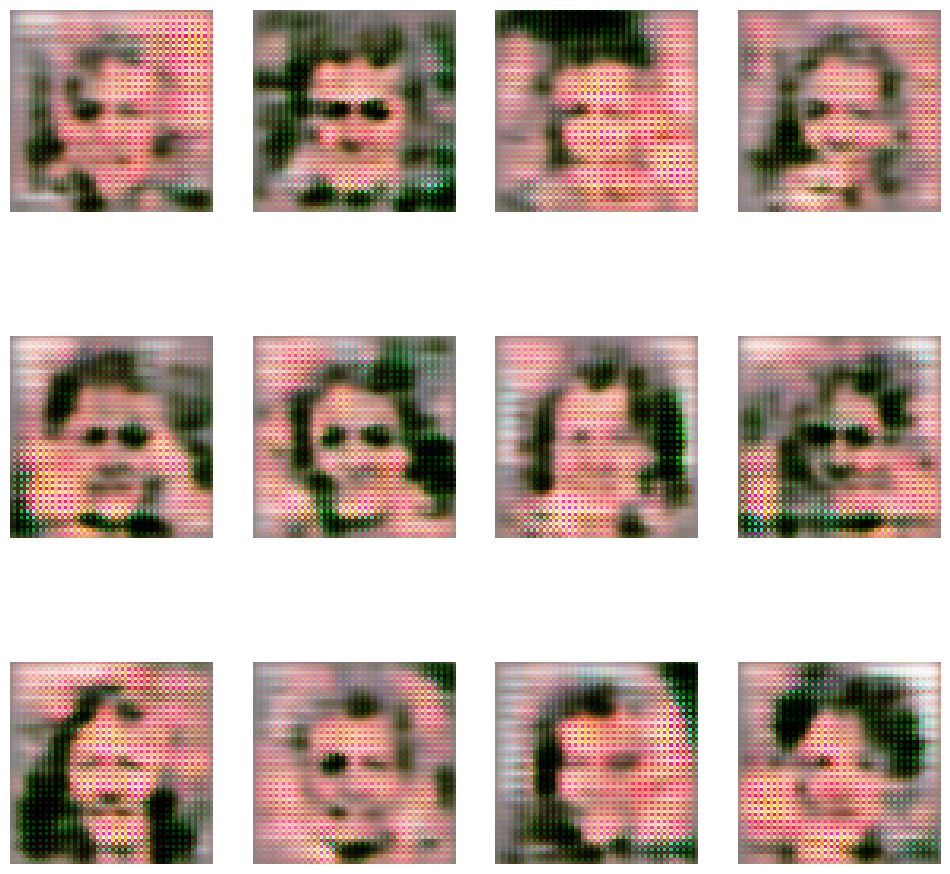

In [20]:
plot_gan_images(gan)

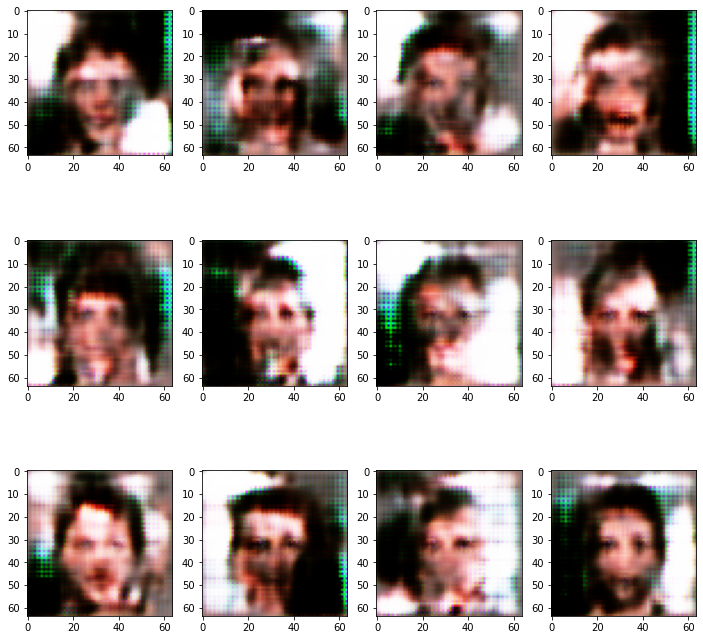

In [59]:
plot_gan_images(gan)

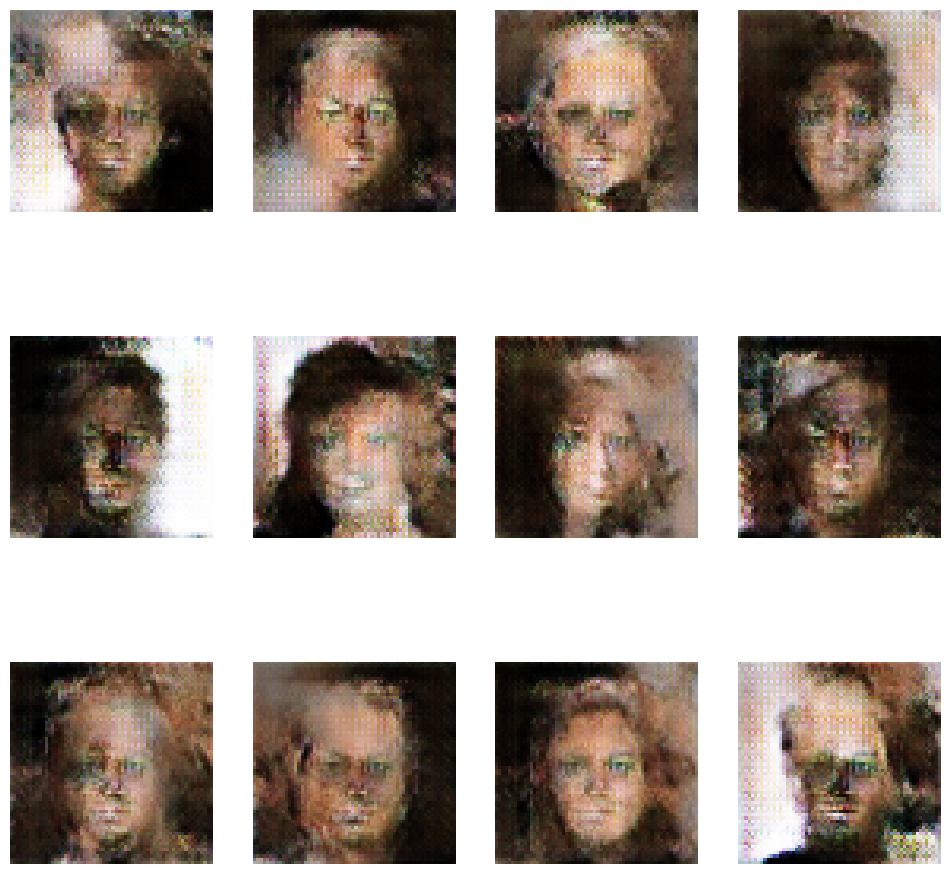

In [24]:
plot_gan_images(gan) # after 10 epochs

**Save and reload a model**

In [39]:
discriminator.save_weights(discriminator_path)          # SAVE
generator.save_weights(generator_path)

discriminator_reloaded = build_discriminator()          # REBUILD D & G
generator_reloaded = build_generator()

discriminator_reloaded.load_weights(discriminator_path) # LOAD WEIGHTS
generator_reloaded.load_weights(generator_path)

gan_reloaded = GAN(                                     # REBUILD GAN
    discriminator=discriminator_reloaded,
    generator=generator_reloaded, 
    latent_dim=latent_dim
)

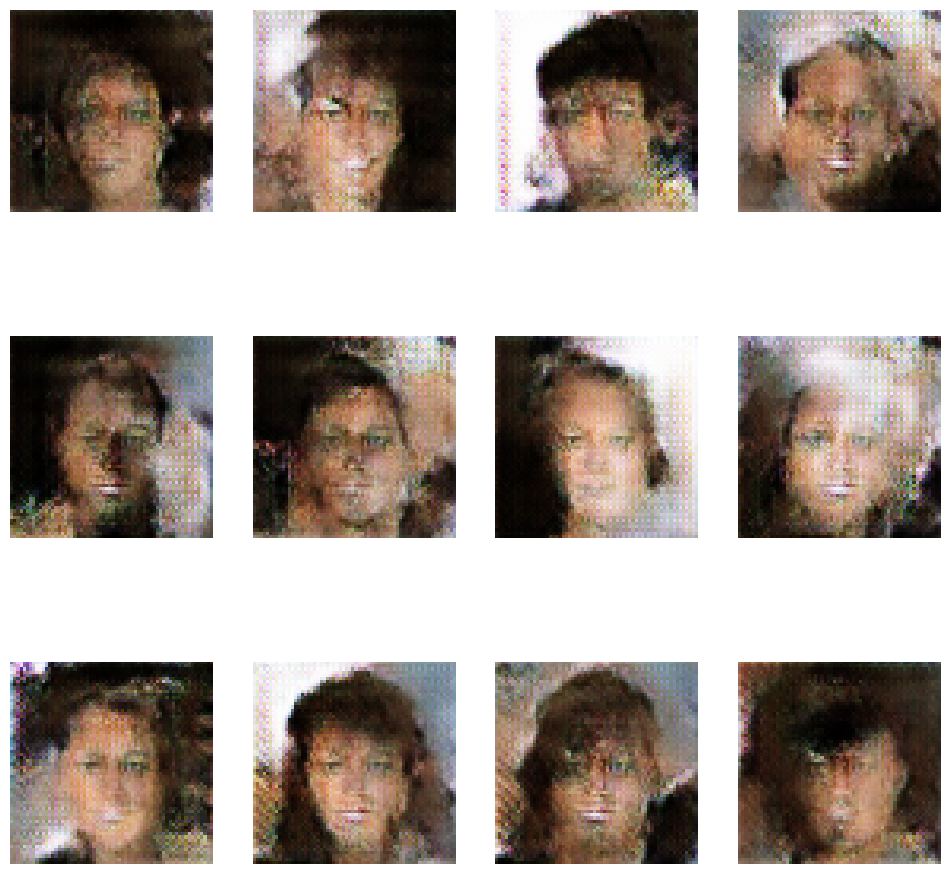

In [40]:
plot_gan_images(gan_reloaded)

### Nvidia's StyleGan 2

<!-- <img src="images/stylegan2-teaser-1024x256.png"> -->
<img src="https://drive.google.com/uc?id=1uOLwpReYnSPNhWsCkYyRjM5YBYXg2cRC">

<small>[Nvidia's StyleGAN 2, 2019](https://github.com/NVlabs/stylegan2)   
[Karras et al., "Analyzing and Improving the Image Quality of StyleGAN"](https://arxiv.org/abs/1912.04958)</small>

### Adversarial attacks

See the notebook [`adversarial-attacks.ipynb`](https://drive.google.com/file/d/1xXRslMkHfSi2Gk6CTvuaCNPFHGAiiVt7/view?usp=share_link) for some examples.

---

### References

[Goodfellow et al. "Generative Adversarial Networks"](https://arxiv.org/abs/1406.2661)

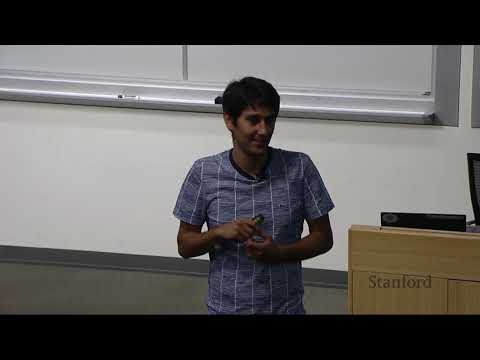

In [4]:
YouTubeVideo('ANszao6YQuM', width=853, height=480) # Stanford CS230: Deep Learning | Autumn 2018 | Lecture 4 - Adversarial Attacks / GANs 

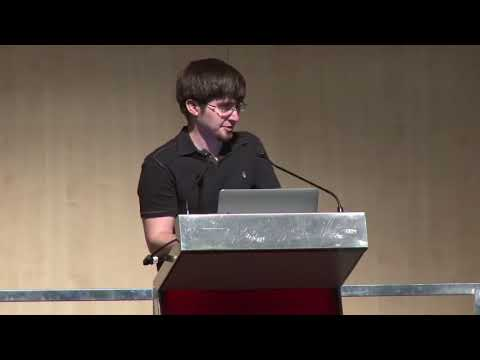

In [5]:
YouTubeVideo('9JpdAg6uMXs', width=853, height=480) # Introduction to GANs, NIPS 2016 | Ian Goodfellow, OpenAI 

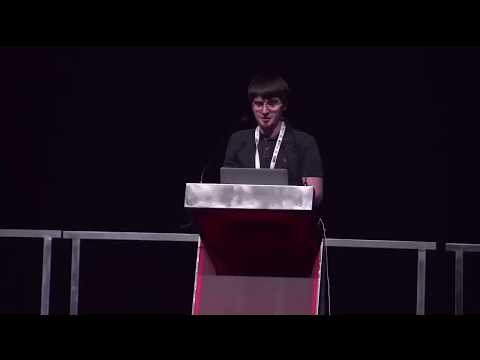

In [6]:
YouTubeVideo('HGYYEUSm-0Q', width=853, height=480) # Ian Goodfellow: Generative Adversarial Networks (NIPS 2016 tutorial) 

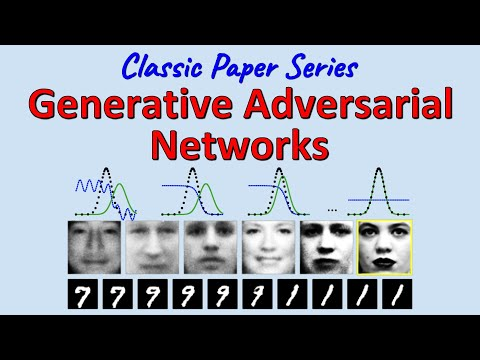

In [7]:
YouTubeVideo('eyxmSmjmNS0', width=853, height=480) # [Classic] Generative Adversarial Networks (Paper Explained) 

### Zoos: list of all GAN variants

When it comes to GANs, the explosion has been so enormous it is rather difficult (impossible?) to keep up:

- [Avinash Hindupur, "The GAN Zoo"](https://github.com/hindupuravinash/the-gan-zoo)
- [Jihye Back, "GAN-Zoos"](https://happy-jihye.github.io/gan/)

### Notable experiments

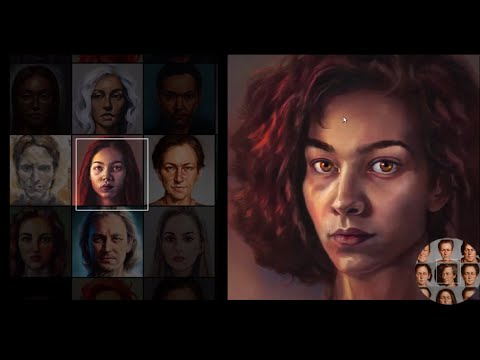

In [2]:
YouTubeVideo('9QuDh3W3lOY', width=853, height=480) # Synthesizing High-Resolution Images with StyleGAN2 

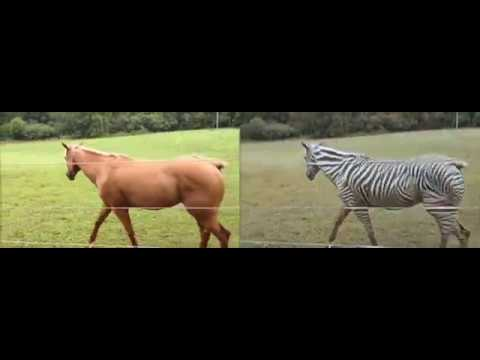

In [3]:
YouTubeVideo('9reHvktowLY', width=853, height=480) # CycleGAN horse zebra 0'7

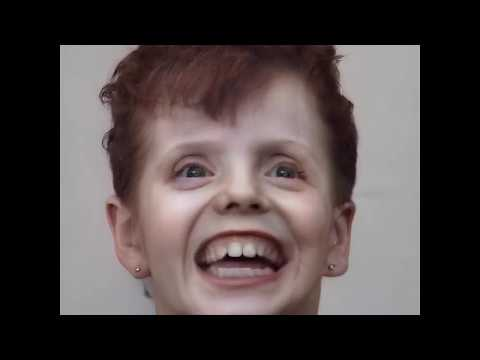

In [4]:
YouTubeVideo('A6bo_mIOto0', width=853, height=480) # Mario Klingemann: StyleGAN2 - mapping music to facial expressions in real time

---

### 12.5.7 Wrapping up

- A GAN is made of **two parts**:
    - a **generator** network coupled to  
    - a **discriminator** network;  
- The discriminator
    - reads batches of real and fake data;
    - **classifies images** (real or not); 
- The generator 
    - **never sees real images**;  
    - only knows **if it fools the discriminator**;  


### Training

- GANs are difficult to train because they lack a static loss landscape;  
- Many tricks are needed, and a lot of training; 
- GANs can nevertheless generate **highly realistic images**;  
- However, the **latent space is almost certainly unstructured**;  
- It will **not possess concept vectors**.

## Generative Deep Learning Summary

- Text generation
- DeepDream
- Neural style transfer
- Variational autoencoders
- Generative adversarial networks


---

## The Current Craze: Diffusion!

#### Tutorials

[Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)  
[High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)  
[A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/)

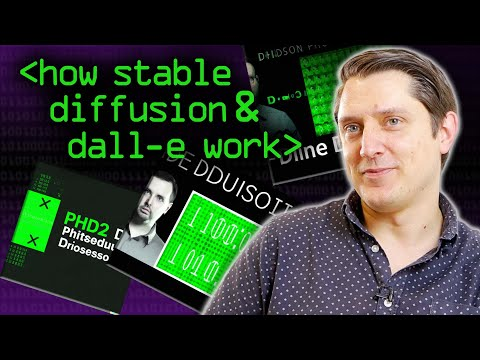

In [9]:
YouTubeVideo('1CIpzeNxIhU', width=853, height=480) #  How AI Image Generators Work (Stable Diffusion / Dall-E) - Computerphile 

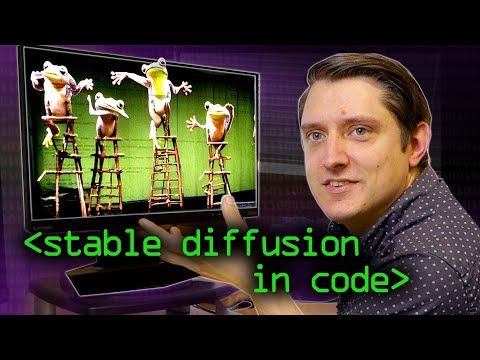

In [10]:
YouTubeVideo('-lz30by8-sU', width=853, height=480) #  Stable Diffusion in Code (AI Image Generation) - Computerphile 

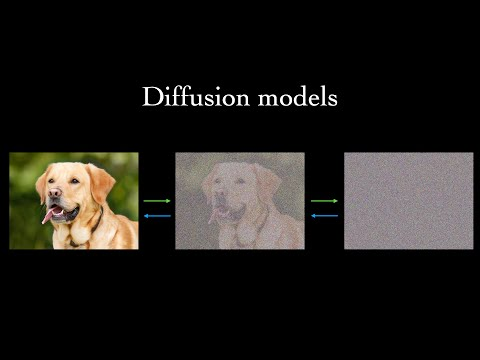

In [11]:
YouTubeVideo('fbLgFrlTnGU', width=853, height=480) #  What are Diffusion Models? 

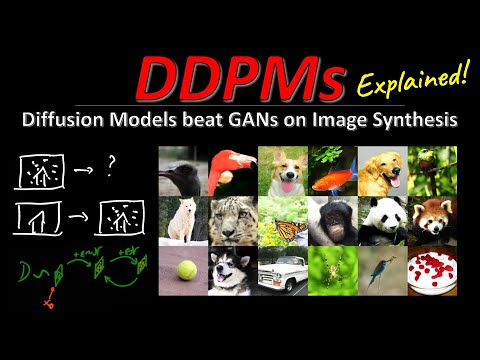

In [12]:
YouTubeVideo('W-O7AZNzbzQ', width=853, height=480) #  DDPM - Diffusion Models Beat GANs on Image Synthesis (Machine Learning Research Paper Explained) 

Also the series of videos by [Fast.ai](https://www.fast.ai/):
- [Lesson 9: Deep Learning Foundations to Stable Diffusion, 2022](https://www.youtube.com/watch?v=_7rMfsA24Ls)
- [Lesson 9A 2022 - Stable Diffusion deep dive](https://www.youtube.com/watch?v=0_BBRNYInx8)
- [Lesson 9B - the math of diffusion](https://www.youtube.com/watch?v=mYpjmM7O-30)
- [Lesson 10: Deep Learning Foundations to Stable Diffusion, 2022](https://www.youtube.com/watch?v=6StU6UtZEbU)